In [430]:
import os
os.chdir("/Users/davidamat/Documents/Projects/deepsetstats")
# os.chdir("/Users/davidamat/Documents/Personal/deepsetstats")

from deepsetstats.utils import utils_tools
from deepsetstats.utils import constants as c
from deepsetstats.utils import videocapture as vc
from deepsetstats.court_detection import edge_detection

import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import copy
import torch
import time
import scipy.spatial as sp
from skimage.color import rgb2hsv, hsv2rgb

In [431]:
%matplotlib inline
from importlib import reload
np.set_printoptions(threshold=2000)

In [432]:
def rel():
    global utils_tools
    global c
    global vc
    global edge_detection
    utils_tools = reload(utils_tools)
    c = reload(c)
    vc = reload(vc)
    edge_detection = reload(edge_detection)

In [433]:
# Constants
rel()

# 1. Load Videos and Dictionary of vids

In [434]:
# Dictionary of vids
extension = ".mp4"
gs = ["wb", "rg", "ao", "us"]

#c.PATH_VIDS = "/Users/davidamat/Documents/BackUp/DeepSetStats"
d_path_vids = {vid: str(Path(c.PATH_VIDS) / (vid + extension)) for vid in gs }
VC = vc.VideoClass(d_path_vids["rg"])
d_vc = { grandslam: vc.VideoClass(d_path_vids[grandslam]) for grandslam in gs}

# 2. Load frames

In [6]:
l_frames = [29*25, 29*25, 29*25, 25*25]
# in Color
d_f = {
   grandslam: d_vc[grandslam].get_frame(frame_num) for grandslam, frame_num in zip(gs, l_frames)
}

# In Black and White
d_fg = {
   grandslam: d_vc[grandslam]._correct_color(d_f[grandslam], gray=True) for grandslam in gs
}

# 3. Court Detection

In [54]:
# Input frame
tourn = "ao"
frame = d_f[tourn].copy()
frameg = d_fg[tourn].copy()
vt = d_vc[tourn]

## 3.1 Court Type

In [8]:
%%time
# Court type
rgb_court, court_type = VC.detect_court(frame)
print(f"Court Type: {court_type}")
print(f"Court RGB Colors: {c.D_GRAD_LINES[court_type]}")

Court Type: GREENSET_AO
Court RGB Colors: {'COURT': array([108, 156, 196]), 'LINE_CLEAN': array([200, 228, 240]), 'LINE_DIRTY': array([125, 180, 224])}
CPU times: user 2.67 ms, sys: 1.57 ms, total: 4.24 ms
Wall time: 2.61 ms


## 3.2 White Filtering

In [726]:
tourn = "ao"

In [727]:
%%time
frameg = d_fg[tourn].copy()
frame = d_f[tourn].copy()

CPU times: user 1.18 ms, sys: 662 µs, total: 1.84 ms
Wall time: 990 µs


In [728]:
%%time
ED = edge_detection.EdgeDetect(th=30)
mask_edges = ED.img2edges(frameg)

CPU times: user 68.9 ms, sys: 7.57 ms, total: 76.5 ms
Wall time: 74.9 ms


## Line Grid points

In [749]:
h,w,_ = frame.shape

In [759]:
# OPTION 1: Equispaced Nodes
x_slices = 10
y_slices = 10
marg_x = w // 20
marg_y = h // 20
x_vlines = np.linspace(marg_x, w - marg_x, x_slices, dtype=np.int16)
y_hlines = np.linspace(marg_y, h - marg_y, y_slices, dtype=np.int16)
y_diff = np.diff(y_hlines)[0]
x_diff = np.diff(x_vlines)[0]
# Ensure y_diff > linewidth !!!

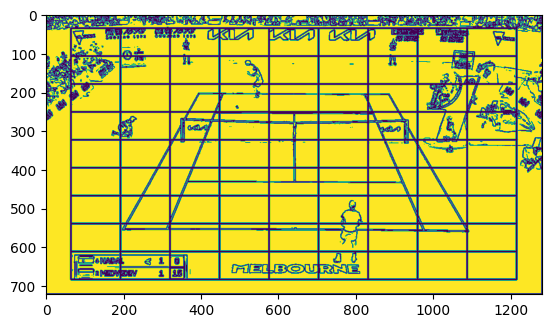

In [760]:
# Visualize strategy
mask_edges_grid = mask_edges.copy()
for xx in x_vlines:
    cv2.line(mask_edges_grid, (xx, min(y_hlines)), (xx, max(y_hlines)), (0, 255, 0), 3)
for yy in y_hlines:
    cv2.line(mask_edges_grid, (min(x_vlines), yy), (max(x_vlines), yy), (0, 0, 255), 3)
VC.show_frame(mask_edges_grid)

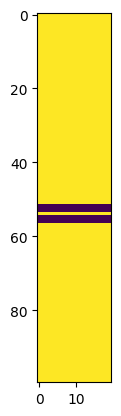

In [773]:
VC.show_frame(mask_edges[500:600,438:458])

In [790]:
mask_inv = np.abs(mask_edges-1)
mask_inv

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 0., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [761]:
x_vlines[3]

448

In [772]:
y_hlines[-4]

468

In [814]:
marg = 30
#vl = mask_edges[y_hlines[0]:y_hlines[-1], x_vlines[3]-marg:x_vlines[3]+1+marg]
vl = mask_inv[y_hlines[-10]+marg_y:y_hlines[-1]+marg_y, x_vlines[3]-marg+marg_x:x_vlines[3]+1+marg+marg_x]

In [811]:
# Compact lines
for idx in vl.ravel():
    continue

In [829]:
sl = vl[100:240, 35:36]

In [832]:
find_1 = np.where(sl)[0]
find_1

array([ 32,  34,  82,  84, 102, 103, 104, 106, 107])

In [833]:
np.ediff1d(find_1)

array([ 2, 48,  2, 18,  1,  1,  2,  1])

In [828]:
vl[100:240, 35:36].ravel()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [854]:
%%time
sl = vl[:, 35:36]
find_1 = np.where(sl)[0]
np.ediff1d(find_1)

CPU times: user 110 µs, sys: 14 µs, total: 124 µs
Wall time: 117 µs


array([  1,   1,   1,   6,   1,   1,  74,   2,  48,   2,  18,   1,   1,
         2,   1,  46,   6,  99,   1,   1,   1, 119,   1,   2,   1,  90,
         1,  19,   1])

In [842]:
find_1

array([ 47,  48,  49,  50,  56,  57,  58, 132, 134, 182, 184, 202, 203,
       204, 206, 207, 253, 259, 358, 359, 360, 361, 480, 481, 483, 484,
       574, 575, 594, 595])

In [839]:
vl[400:600, 35:36].ravel()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])

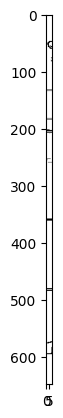

In [846]:
VC.show_gray(vl[:, 30:40])

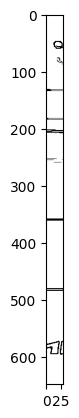

In [847]:
VC.show_gray(vl[:, 20:50])

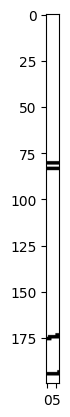

In [838]:
VC.show_gray(vl[400:600, 32:39])

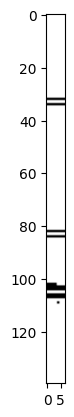

In [827]:
VC.show_gray(vl[100:240, 32:39])

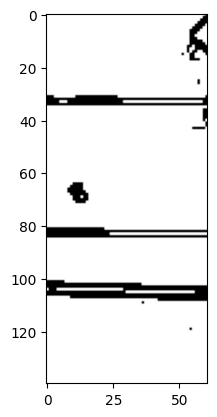

In [823]:
VC.show_gray(vl[100:240, :])

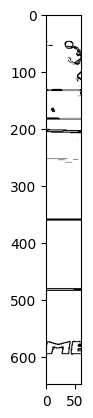

In [835]:
VC.show_gray(vl)

In [752]:
y_diff

27

## Lines in range of colors line colors of that court type

In [729]:
import colorsys
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv

In [730]:
RGB_WHITE = np.array([255,255,255])

In [731]:
## convert to hsv
frame_hsv = rgb2hsv(frame)

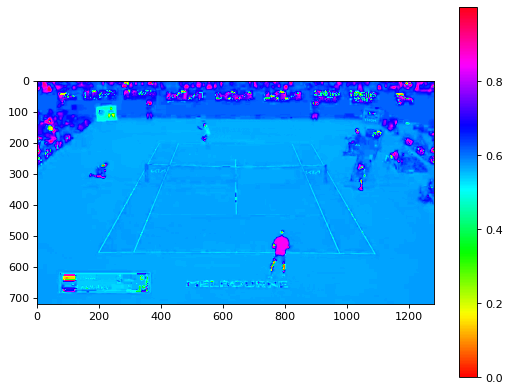

In [732]:
VC.vis.display_hue(frame_hsv)

In [733]:
%%time
hist, bin_edges = np.histogram(frame_hsv[:,:,0].ravel(), bins=np.round(np.linspace(0,1, 10), 1))

CPU times: user 31.5 ms, sys: 1.28 ms, total: 32.8 ms
Wall time: 30.8 ms


In [734]:
hist

array([  3796,   1749,    291,    165, 723927, 150068,  26052,  11196,
         4356])

In [735]:
bin_edges

array([0. , 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1. ])

In [736]:
frame_hsv[:,:,0].ravel()

array([0.6969697 , 0.6969697 , 0.72435897, ..., 0.57338308, 0.57338308,
       0.57338308])

In [737]:
rgb2hsv(c.RGB_AO)

array([5.75757576e-01, 4.48979592e-01, 2.12503626e-17])

In [738]:
rgb2hsv(RGB_WHITE)

array([0.00000000e+00, 0.00000000e+00, 2.76471554e-17])

In [739]:
hue_clay, sat_clay = rgb2hsv(c.RGB_LINE_GREENSET_AOd + tol)[0], rgb2hsv(c.RGB_LINE_GREENSET_AOd + tol)[1]
hue_lined, sat_lined = rgb2hsv(RGB_WHITE)[0], rgb2hsv(RGB_WHITE)[1]

In [740]:
hue_clay, sat_clay

(0.5740740740740741, 0.4057377049180328)

In [741]:
hue_lined, sat_lined

(0.0, 0.0)

In [742]:
%%time
lower_mask = frame_hsv [:,:,0] > 1
upper_mask = frame_hsv [:,:,0] < hue_clay + 0.1
saturation = (frame_hsv [:,:,1] > 0)

CPU times: user 7.55 ms, sys: 1.14 ms, total: 8.69 ms
Wall time: 6.95 ms


In [743]:
%%time
mask = np.logical_and(np.logical_or(upper_mask, lower_mask), saturation)

CPU times: user 1.43 ms, sys: 845 µs, total: 2.27 ms
Wall time: 1.06 ms


In [744]:
%%time
mask = np.uint8(mask)
linewdith_blur = 10
kernel = np.ones((linewdith_blur,linewdith_blur),np.float32)/linewdith_blur**2
mask = cv2.filter2D(mask,-1,kernel)

CPU times: user 7.84 ms, sys: 1.35 ms, total: 9.19 ms
Wall time: 7.33 ms


In [745]:
%%time
red = frame[:,:,0]*mask
green = frame[:,:,1]*mask
blue = frame[:,:,2]*mask
frame_color_masked = np.dstack((red,green,blue))

CPU times: user 4.54 ms, sys: 699 µs, total: 5.24 ms
Wall time: 3.87 ms


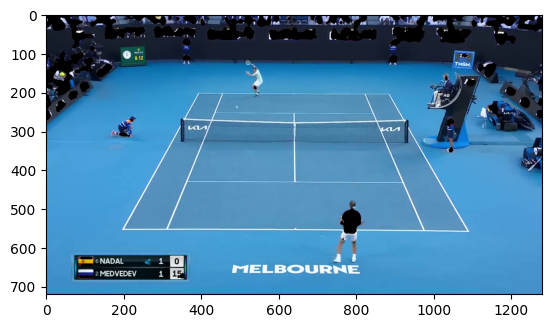

In [746]:
VC.show_frame(frame_color_masked)

In [634]:
arr = frame_hsv.reshape(-1, 3)

In [642]:
col1 = np.round(rgb2hsv(c.RGB_LINE_CLAYd + tol),4)
col2 = np.round(rgb2hsv(c.RGB_COURTS + tol),4)

array([0.0467, 0.3923, 0.    ], dtype=float16)

In [648]:
%%time
## mask of white line
mask_white_line = cv2.inRange(frame_hsv, np.float16(col1), np.float16(HSV_WHITE))

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'inRange'
> Overload resolution failed:
>  - lowerb data type = 23 is not supported
>  - Expected Ptr<cv::UMat> for argument 'lowerb'


In [650]:
cv2.inRange?

Docstring:
inRange(src, lowerb, upperb[, dst]) -> dst
.   @brief  Checks if array elements lie between the elements of two other arrays.
.   
.   The function checks the range as follows:
.   -   For every element of a single-channel input array:
.       \f[\texttt{dst} (I)= \texttt{lowerb} (I)_0  \leq \texttt{src} (I)_0 \leq  \texttt{upperb} (I)_0\f]
.   -   For two-channel arrays:
.       \f[\texttt{dst} (I)= \texttt{lowerb} (I)_0  \leq \texttt{src} (I)_0 \leq  \texttt{upperb} (I)_0  \land \texttt{lowerb} (I)_1  \leq \texttt{src} (I)_1 \leq  \texttt{upperb} (I)_1\f]
.   -   and so forth.
.   
.   That is, dst (I) is set to 255 (all 1 -bits) if src (I) is within the
.   specified 1D, 2D, 3D, ... box and 0 otherwise.
.   
.   When the lower and/or upper boundary parameters are scalars, the indexes
.   (I) at lowerb and upperb in the above formulas should be omitted.
.   @param src first input array.
.   @param lowerb inclusive lower boundary array or a scalar.
.   @param upperb inclusi

In [357]:
from collections import Counter

In [358]:
Counter(np.ravel(mask_white_line))

Counter({0: 921600})

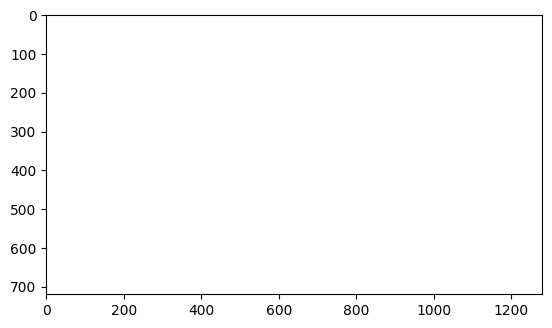

In [359]:
VC.show_gray(mask_white_line)

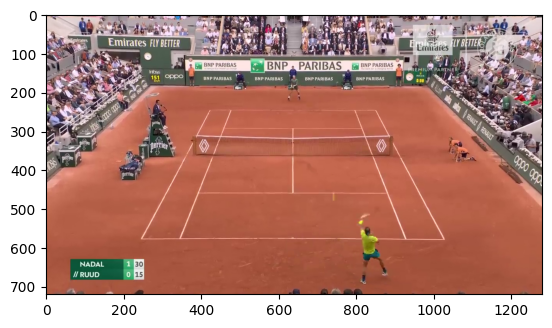

In [275]:
VC.show_frame(frame)

In [ ]:






## mask o yellow (15,0,0) ~ (36, 255, 255)
mask2 = cv2.inRange(hsv, (15,0,0), (36, 255, 255))

## final mask and masked
mask = cv2.bitwise_or(mask1, mask2)
target = cv2.bitwise_and(img,img, mask=mask)

cv2.imwrite("target.png", target)

In [ ]:
result = cv2.bitwise_and(nemo, nemo, mask=mask)
mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)

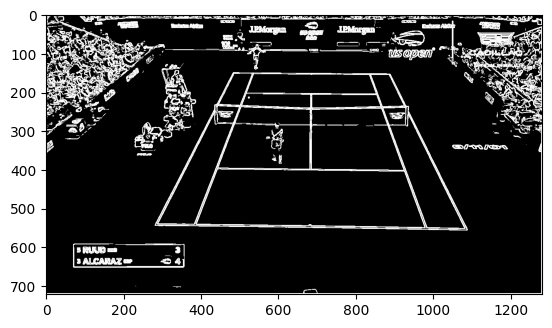

In [227]:
VC.show_gray(mask_edges*255)

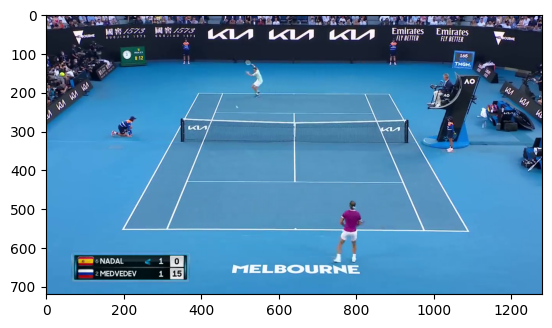

CPU times: user 352 ms, sys: 33.5 ms, total: 386 ms
Wall time: 292 ms


In [9]:
%%time
#mask_lines = VC.get_line_mask(frame, court_type)
#VC.show_gray(mask_lines)
#VC.show_gray(mask_lines[500:600,200:300])
VC.show_frame(frame)

In [11]:
%%time
grad = gradient_image.GradientImage()
frame_up, frame_down, frame_left, frame_right = grad.get_grads(frame)

hola
CPU times: user 19.5 ms, sys: 19.6 ms, total: 39.2 ms
Wall time: 37.6 ms


In [12]:
%%time
fdup, fddown, fddleft, fddright = grad.get_frame_directions_diff(frame)
mask_lines_bin = np.maximum(grad.shift_frame_down(fdup), grad.shift_frame_left(fddright))
mask_lines_bin2 = np.maximum(grad.shift_frame_up(fddown), grad.shift_frame_right(fddleft))
mask_both = grad.multiply_diffs(mask_lines_bin, mask_lines_bin2)

CPU times: user 112 ms, sys: 23.4 ms, total: 135 ms
Wall time: 134 ms


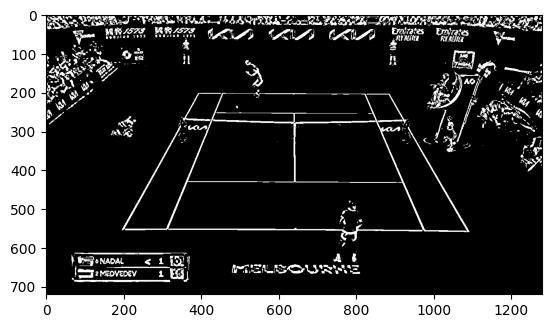

In [13]:
mask_final = grad.apply_threshold(mask_both, th=30)
VC.show_gray(mask_final*255)

In [160]:
val = 1
my_filter = np.array([
    [-val, 0, val],
    [-val, 0, val],
    [-val, 0, val],
])

In [172]:
%%time
vertical_edges = signal.correlate(frameg, my_filter, method="fft")
horizontal_edges = signal.correlate(frameg, my_filter.T, method="fft")

CPU times: user 61.7 ms, sys: 13.3 ms, total: 75.1 ms
Wall time: 72.8 ms


In [173]:
%%time
edges = np.sqrt(vertical_edges**2 + horizontal_edges**2)

CPU times: user 7.07 ms, sys: 2.27 ms, total: 9.33 ms
Wall time: 7.27 ms


In [174]:
%%time
edges_scaled = (255 / np.max(edges)) * edges

CPU times: user 2.62 ms, sys: 640 µs, total: 3.26 ms
Wall time: 2.16 ms


In [175]:
np.max(edges_scaled)

255.0

In [176]:
mask_edges = grad.apply_threshold(edges_scaled, th=50)


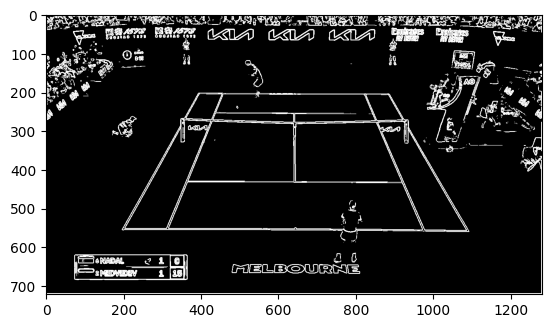

In [177]:
VC.show_gray(mask_edges*255)

## 3.3 Line Point detection

In [178]:
mask_final[426:436,544:545]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.]])

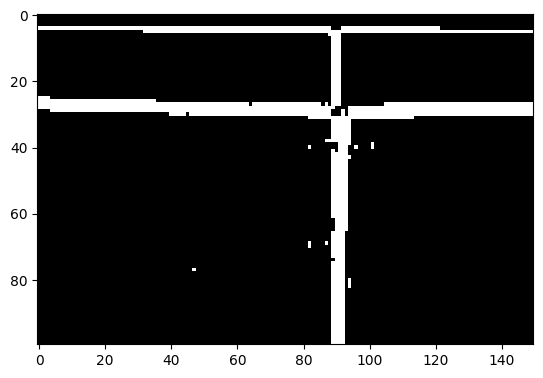

In [181]:
VC.show_gray(mask_final[250:350,550:700])

In [45]:
%%time
framef = frame.copy()
# Find the edges in the image using canny detector
edges = cv2.Canny(np.uint8(mask_final*255), 50, 150)
# Detect points that form a line
lines = cv2.HoughLines(edges, 1, np.pi/180, 5)

CPU times: user 32.8 ms, sys: 2.92 ms, total: 35.7 ms
Wall time: 31.5 ms


In [48]:
for line in lines:
    break

In [49]:
line

array([[551.       ,   1.5707964]], dtype=float32)

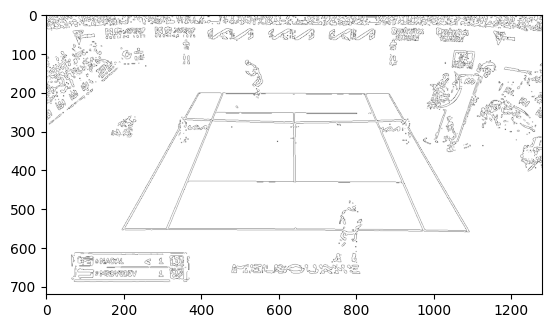

In [46]:
VC.show_gray(edges)

In [47]:
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(framef, (x1, y1), (x2, y2), (255, 0, 0), 3)
# Show result
VC.show_gray(framef)

ValueError: not enough values to unpack (expected 4, got 2)

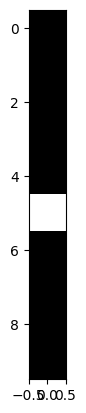

In [31]:
VC.show_gray(mask_final[426:436,544:545]*255)

In [372]:
gray = np.uint8(mask_final*255)
framef = frame.copy()

In [368]:
%%time
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
edges = cv2.Canny(mask_both,50,150,apertureSize = 3)

CPU times: user 10 ms, sys: 10.1 ms, total: 20.2 ms
Wall time: 9.74 ms


In [398]:
# https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html

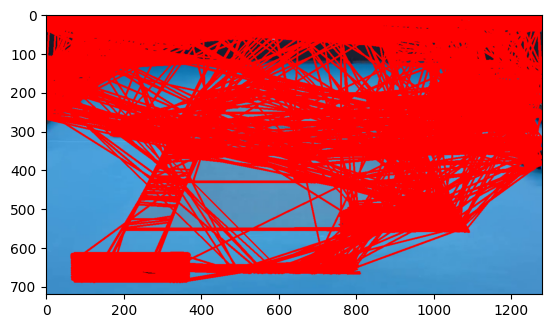

In [397]:
framef = frame.copy()
# Find the edges in the image using canny detector
edges = cv2.Canny(np.uint8(mask_both), 50, 150)
# Detect points that form a line
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 5, minLineLength=10, maxLineGap=250)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(framef, (x1, y1), (x2, y2), (255, 0, 0), 3)
# Show result
VC.show_frame(framef)

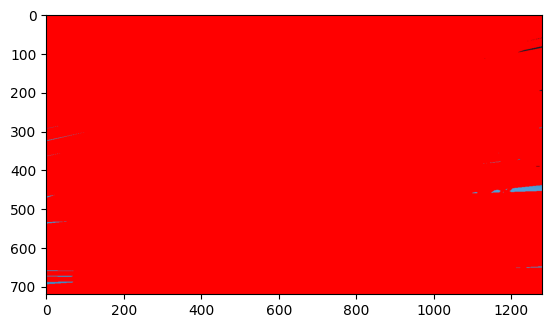

In [387]:
VC.show_frame(framef)

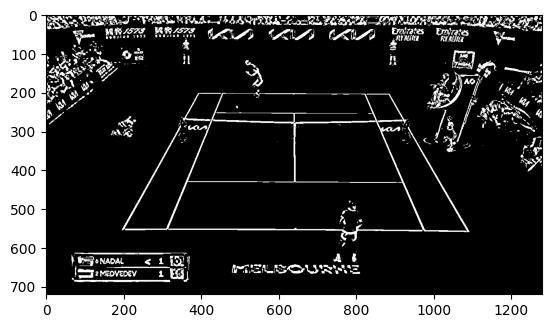

## Closest color

In [22]:
%%time
input_color = (100, 50, 25)
websafe_colors = [(200, 100, 50), (151,101,100)] # list of web-save colors
tree = sp.KDTree(websafe_colors) # creating k-d tree from web-save colors
ditsance, result = tree.query(input_color) # get Euclidean distance and index of web-save color in tree/list
nearest_color = websafe_colors[result]

CPU times: user 458 µs, sys: 162 µs, total: 620 µs
Wall time: 509 µs


In [23]:
ditsance

104.05287117614775

### Correct Slice

In [126]:
slif = frame[285:300, 505:506]
slim = mask_lines_bin[200:245, 400:655]

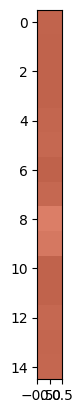

In [127]:
VC.show_frame(slif)

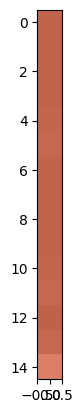

In [139]:
VC.show_frame(frame_down)

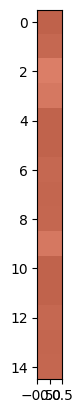

In [130]:
VC.show_frame(frame_up)

In [129]:
grad = GradientImage(slif)
frame_up, frame_down, frame_left, frame_right = grad.get_grads()

In [131]:
diff_up = slif - frame_up

In [138]:
diff_up

array([[[  2,   2,   2]],

       [[ -5,  -5,  -5]],

       [[-27, -27, -27]],

       [[-21, -21, -21]],

       [[  3,   3,   3]],

       [[  5,   5,   5]],

       [[ -6,  -6,  -6]],

       [[  2,   2,   2]],

       [[ 23,  23,  23]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]]])

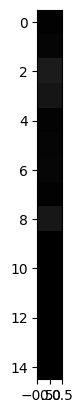

In [136]:
VC.show_frame(np.abs(diff_up))

In [307]:
sli.min(axis=1)

array([255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
         0.,   0.,   0., 255., 255., 255., 255., 255., 255.])

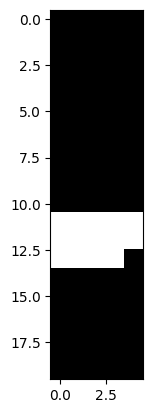

In [308]:
VC.show_gray(sli)

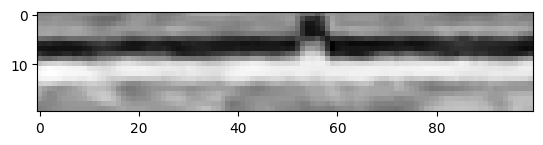

In [184]:
VC.show_gray(frame_diff_down[625:645, 600:700])

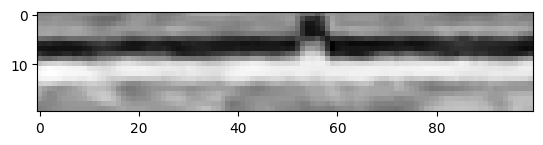

In [185]:
VC.show_gray(frame_diff_up[625:645, 600:700])

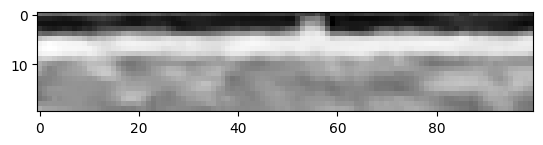

In [175]:
VC.show_gray(frame_diff_up_to_down[625:645, 600:700])

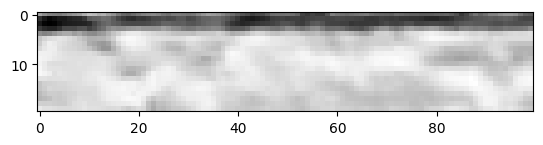

In [176]:
VC.show_gray(frame_diff_down_to_up[625:645, 600:700])

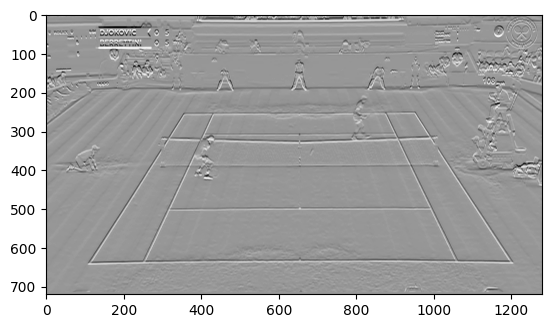

In [143]:
VC.show_gray(frame_diff_up)

In [106]:
np.max(frame_diff)

255.0

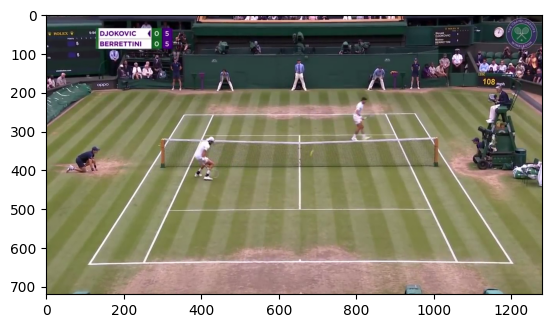

In [116]:
VC.show_frame(frame_down)